<a href="https://colab.research.google.com/github/Sopralapanca/Pattern-Recognition/blob/main/Assignment_5_SIFT_Christian_Peluso.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 5

Select four thematic subsets of your choice, out of the total 8 available, and collect all the associated images. For these images, extract the SIFT descriptors using the visual feature detector embedded in SIFT to identify the points of interest. Aggregate all the identified descriptors in a dataset and run k-means (or any clustering algorithm of your choice) on such data to partition the descriptors in clusters. Then analyze the obtained clusters by confronting the descriptors assigned to each cluster with the thematic classes of the images from which they were extracted (in other words, compute a confusion matrix between the clusters and the four thematic images). Discuss your findings. Choice of the number of clusters and of the clustering algorithm is on you (and should be discussed in the report).

[Link to the Dataset](http://download.microsoft.com/download/A/1/1/A116CD80-5B79-407E-B5CE-3D5C6ED8B0D5/msrc_objcategimagedatabase_v1.zip)

In [ ]:
!pip install kneed &> /dev/null

In [ ]:
!gdown --id "154Qo4CtzdwwMtY7xwd0dQXFBweWmva0h&confirm=t"

/usr/local/lib/python3.9/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=154Qo4CtzdwwMtY7xwd0dQXFBweWmva0h&confirm=t
To: /content/images_ds.zip
100% 21.3M/21.3M [00:00<00:00, 108MB/s] 


In [ ]:
import os
import zipfile
import cv2 as cv
import pandas as ps
import numpy as np
from kneed import KneeLocator
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import MinMaxScaler

with zipfile.ZipFile( "/content/images_ds.zip", 'r') as zips:
  zips.extractall( '/content/')

In [ ]:
#@title Utils { display-mode: "form" }
from yellowbrick.cluster import intercluster_distance
from IPython.display import HTML as html_print

def knee_method(x_ax, y_ax, direction='increasing', labelx="", labely="", returnX=True, show_plot=True):
  knee = KneeLocator(x_ax, y_ax, S=1, curve='convex', direction=direction, interp_method='polynomial')
  if show_plot:
    fig = plt.figure(figsize=(5, 5))
    knee.plot_knee()
    plt.xlabel(labelx)
    plt.ylabel(labely)
    plt.grid(visible=True)
    plt.show()
  return knee.knee

def cluster_distance(clustering_alg, values):
  fig, ax = plt.subplots()
  intercluster_distance(clustering_alg, 
                        values, 
                        embedding='mds', is_fitted=True,
                        random_state=42,
                        normalized_stress='auto')

def cstr(s, color='black'):
    return "<text style=color:{}>{}</text>".format(color, s)

def target_generator():
  y=[range]
  for i in range(120):
    y.append(i//30)
  return y[1:]

def plot_grids(n, results, hist=True):
  # code for displaying multiple images in one figure
  classes = {
      3: 'House',
      4: 'Airplane',
      7: 'Car',
      8: 'Bycicle'
  }
  fig = plt.figure(figsize=(15, 7))
  rows = 3
  columns = 4
  # reading referement images
  for i, c in enumerate(classes.keys()):
    img = cv.imread('dataset/'+str(c)+'_'+str(1+n)+'_s.bmp')
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(str(classes[c]))
    
  if hist:
    # creating the histogram of the clustered descriptors in the images
    for i, c in enumerate(classes.keys()):
      x = np.arange(len(predictions[i*30+n]))
      fig.add_subplot(rows, columns, i+columns+1)
      plt.bar(x, predictions[i*30+n], color=hex_colors, edgecolor='black')
      plt.axis('off')

  # reading result images
  for i, c in enumerate(classes.keys()):
    img = cv.imread(results+'/'+str(c)+'_'+str(1+n)+'_s.jpg')
    fig.add_subplot(rows, columns, i+columns+columns+1)
    plt.imshow(img)
    plt.axis('off')

hex_colors = ['#FF0000', '#00FF00', '#0000FF', '#FFFF00', '#FF8000', '#00FFFF', '#8000FF', '#008000']
fte_colors = [(255,0,0), (0,255,0), (0,0,255), (255,255,0), (255,128,0), (0,255,255), (128,0,255), (0,128,0)]

string = '' 
for cluster_id, theColor in enumerate(hex_colors):
  left, word = 'Cluster '+str(cluster_id)+' '+str(theColor), '■■■■■■■■■■■■'
  string += cstr(' '.join([left, cstr(word, color=theColor)])) +"<br>"
html_print(string)

## How can SIFT extract this features?

Here we are converting the images in gray scale in order to better recognize the luminance differences. Instead of computing the gradient over the pixels (because it is costly) we are extracting the octaves and the blurred, thanks to the Gaussian filter, and computing the differences over them; this operation is called DoG - Difference of Gaussians, that is an approximation of the gradient talked before, thus can lead to poor results. Thanks to the Taylor series computation over the DoG we are reaching an interesting trade off between cost and approximation.

```
sift = cv.SIFT_create(nfeatures, nOctaveLayers, contrastThreshold, edgeThreshold, 
                      sigma, descriptorType[, enable_precise_upscale])
```
The *contrastThreshold* and the *edgeThreshold* are useful in order to avoid small and high gradient differences that are associated to no luminance changes and edges of shapes respectively.

In [ ]:
descriptors=[]
if not os.path.exists('results'):
    os.makedirs('results')
dataset_imgs = os.listdir("dataset")
sift = cv.SIFT_create(0, 3, 0.04, 8, 1.6)
for img_name in dataset_imgs:
  if "GT" not in img_name:
    img = cv.imread('dataset/'+img_name)
    gray= cv.cvtColor(img,cv.COLOR_BGR2GRAY)
    kp, des = sift.detectAndCompute(gray,None)
    descriptors.append(des)
    img=cv.drawKeypoints(gray,kp,img,flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

    cv.imwrite('results/'+img_name.replace('.bmp','.jpg'),img)

In [ ]:
# For each image SIFT express the descriptor in 128 bin values, so we can stack 
# all the descriptors in a matrix so we will have bin * descriptors tensor
des_tensor = np.vstack(descriptors)
des_tensor.shape

(55001, 128)

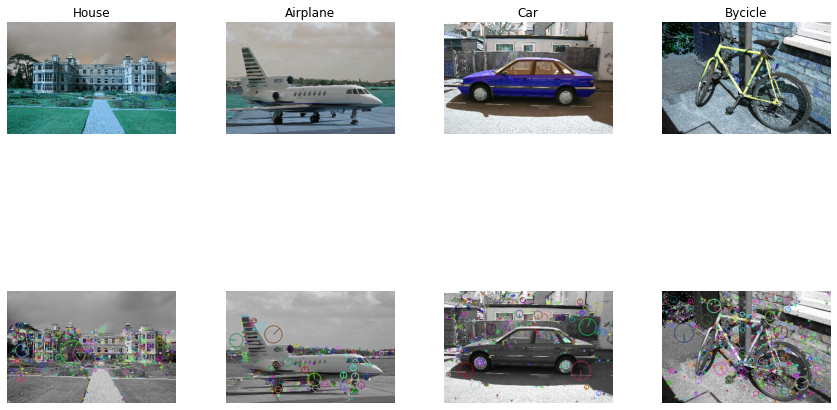

In [ ]:
plot_grids(0, 'results', False)

##Knee Method to estimate the best $k$

In [ ]:
%%time
sse_list  = list()
sil_list  = list() 
k_list    = list()
n_init    = 50
max_iter  = 500
max_k     = 12
for k in range(4, max_k+1):
    kmeans = KMeans(n_clusters=k, n_init=n_init, max_iter=max_iter, random_state=42)
    kmeans.fit(des_tensor)
    sse = kmeans.inertia_
    sse_list.append(sse)
    sil = silhouette_score(des_tensor, kmeans.labels_)
    sil_list.append(sil)
    k_list.append(k)
    print('| {:>3} | {:>12}| {:>20} |'.format(*[k, sse, sil ]))

|   4 | 6548621312.0|  0.05679027736186981 |
|   5 | 6378635264.0| 0.053812526166439056 |
|   6 | 6233699328.0|  0.05513416975736618 |
|   7 | 6098345984.0|  0.05470573157072067 |
|   8 | 5996731904.0| 0.055888742208480835 |
|   9 | 5901196288.0|  0.05723551660776138 |
|  10 | 5824641024.0|   0.0527886301279068 |
|  11 | 5757248000.0| 0.052926480770111084 |
|  12 | 5701250048.0| 0.053223684430122375 |
CPU times: user 26min 23s, sys: 6min 50s, total: 33min 14s
Wall time: 21min 5s


<Figure size 360x360 with 0 Axes>

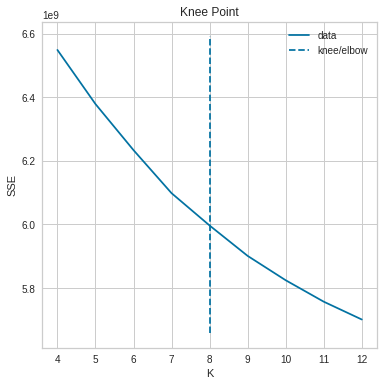

In [ ]:
best_k = knee_method(k_list, sse_list, "decreasing", "K", "SSE", True)

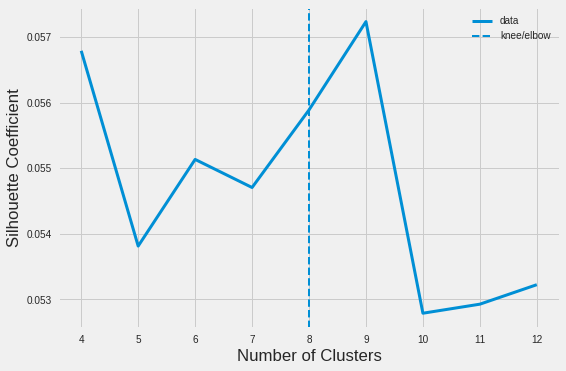

In [ ]:
plt.style.use("fivethirtyeight")
plt.plot(range(4, 13), sil_list, label='data', linewidth=3)
plt.xticks(range(4, 13))
plt.axvline(best_k, 0, 1, linestyle='dashed', linewidth=2, label='knee/elbow')
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.legend(loc="upper right")
plt.show()

## KMeans
So, the best value for the number of cluster is $8$

In [ ]:
n_clusters=best_k

kmeans = KMeans(n_clusters=n_clusters, n_init=n_init, max_iter=max_iter,random_state=42)
kmeans.fit(des_tensor)

KMeans(max_iter=500, n_init=50, random_state=42)

#### Plot the result of clustering with K-Means

/usr/local/lib/python3.9/dist-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


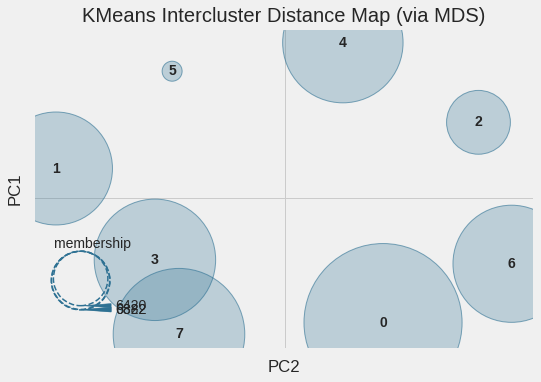

In [ ]:
cluster_distance(kmeans, descriptors)

As we can state from the Intercluster Distance made by the Multidimensional Scale we can see that the clusters are more or less well separeted and have similar dimensions.

In [ ]:
from sklearn.decomposition import PCA as sklearnPCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
import pandas as pd
 
pca = sklearnPCA(n_components=2) #2-dimensional PCA
transformed = pd.DataFrame(pca.fit_transform(des_tensor))

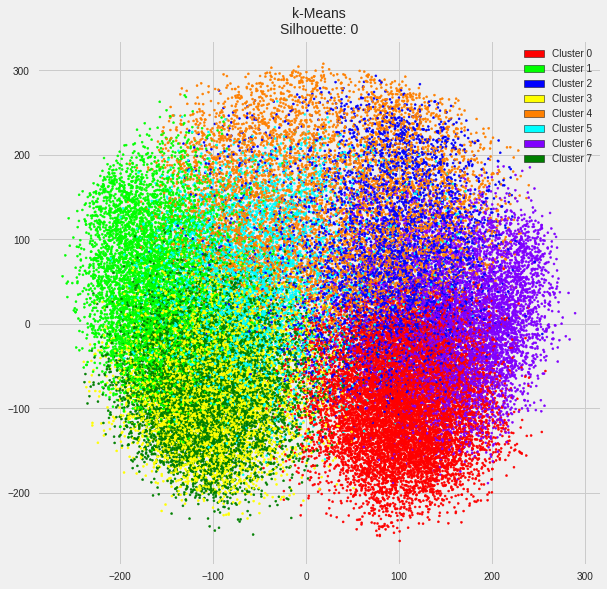

In [ ]:
from matplotlib.patches import Rectangle
labels = ['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4', 'Cluster 5', 'Cluster 6', 'Cluster 7']
plt.figure(figsize=(9, 9))
# The k-means plot
km_colors = [hex_colors[label] for label in kmeans.labels_]
plt.scatter(transformed[0], transformed[1], c=km_colors, s=4)
plt.title(
    f"k-Means\nSilhouette: {0}", fontdict={"fontsize": 14}
)
handles = [Rectangle((0,0),1,1,color=c,ec="k") for c in hex_colors]
plt.legend(handles, labels)
plt.show()

As we can see from the PCA component representation of the descriptors the clusters are well spreaded among thhe surface even being a 128 dimension elements, naturally the cluster 3 and 7 are overlapped as we already saw above.

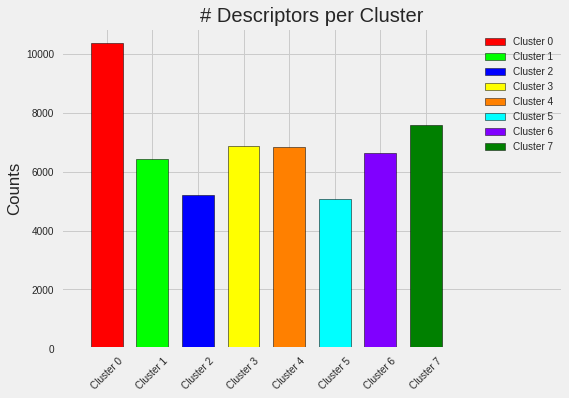

In [ ]:
# Create the histogram
tickvalues = [0, 1, 2, 3, 4, 5, 6, 7]
bins = np.arange(9) - 0.5
n, bin, patches = plt.hist(kmeans.labels_, label=labels, bins=bins, rwidth=0.7, align='mid', edgecolor ='black')
for i in range(len(set(kmeans.labels_))):
  patches[i].set_fc(hex_colors[i])
plt.title('# Descriptors per Cluster')
plt.xticks(tickvalues, labels, rotation=45)
plt.ylabel('Counts')
plt.xlim([-1, 10])
handles = [Rectangle((0,0),1,1,color=c,ec="k") for c in hex_colors]
plt.legend(handles, labels)
plt.show()

It's easier to see the counts of points belonging each cluster with the histogram here reported the 2nd and 5th are the most little, they could mean a gradient that is uncommon or belong a specific class, instead the cluster number 0 is the biggest, maybe it represent a gradient shape really common.

## Representation of the $KP$ for each cluster

In [ ]:
if not os.path.exists('colored_results'):
    os.makedirs('colored_results')
dataset_imgs = os.listdir("dataset")
images_des = []
c=0
# Here we are coloring the descriptors in key point colored as the different 
# clusters in such a way that they are recognizable in the images
for img_name in dataset_imgs:
  if "GT" not in img_name:
    img = cv.imread('dataset/'+img_name)
    gray= cv.cvtColor(img,cv.COLOR_BGR2GRAY)
    keypoints, des = sift.detectAndCompute(gray,None)
    images_des.append(des)
    for i, kp in enumerate(keypoints):
      cluster = kmeans.labels_[i+c]
      color = fte_colors[cluster]
      gray=cv.drawKeypoints(gray, [kp], gray, color, flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
      
    c+=len(keypoints)
    cv.imwrite('colored_results/'+img_name.replace('.bmp','.jpg'),gray)

In [ ]:
# Saving the representation of the cluster per each image in such a way that we 
# can perform the classification on top of them, type of compression thanks to \
# the clusterization finded
predictions = []
for img in images_des:
  _, counts = np.unique(kmeans.predict(img), return_counts=True)
  predictions.append(counts.tolist())

In [ ]:
print(predictions[:5])
print('There is an ensamble of clusters per image indeed the lenght of the above vector is ' + str(len(predictions)))

[[101, 51, 71, 77, 96, 64, 92, 88], [36, 37, 24, 32, 41, 20, 52, 29], [83, 34, 27, 54, 46, 21, 26, 60], [33, 50, 27, 20, 31, 22, 25, 19], [152, 125, 70, 126, 40, 65, 81, 135], [29, 22, 35, 29, 24, 15, 30, 25], [94, 35, 28, 54, 86, 45, 52, 45], [65, 36, 30, 31, 28, 9, 44, 33], [138, 107, 101, 105, 46, 66, 83, 93], [63, 111, 87, 55, 22, 31, 72, 70], [118, 53, 28, 50, 82, 10, 39, 61], [38, 15, 32, 26, 56, 26, 18, 18], [158, 78, 79, 126, 48, 108, 119, 139], [64, 62, 65, 42, 25, 25, 35, 44], [101, 34, 19, 70, 35, 51, 75, 61], [58, 20, 21, 38, 60, 18, 18, 33], [121, 124, 33, 116, 26, 62, 62, 142], [177, 183, 88, 152, 39, 92, 104, 173], [74, 29, 43, 35, 64, 22, 43, 40], [40, 31, 23, 28, 40, 10, 20, 32], [112, 60, 31, 72, 53, 32, 49, 88], [23, 37, 20, 13, 24, 10, 26, 11], [95, 65, 62, 55, 47, 133, 104, 70], [68, 21, 31, 54, 102, 48, 50, 47], [32, 38, 38, 22, 45, 27, 45, 25], [99, 60, 26, 73, 62, 23, 49, 98], [35, 19, 29, 26, 77, 31, 27, 24], [55, 26, 24, 58, 100, 37, 40, 54], [78, 74, 75, 70, 

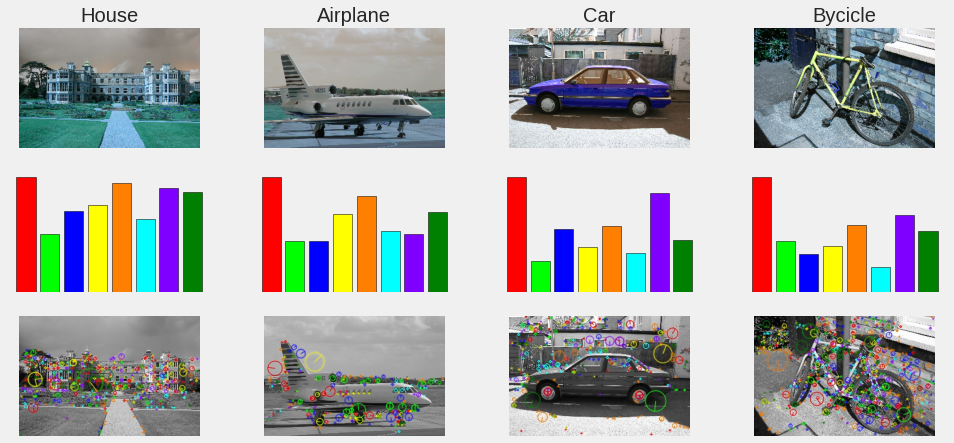

In [ ]:
plot_grids(0, 'colored_results')

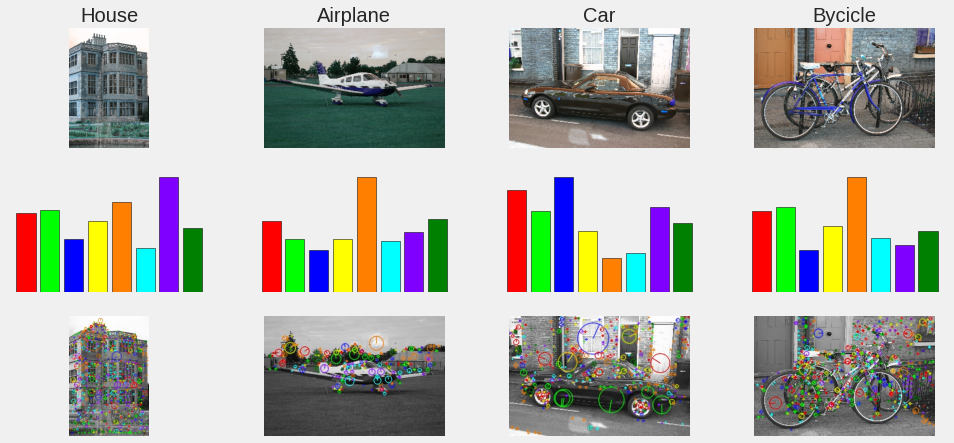

In [ ]:
plot_grids(1, 'colored_results')

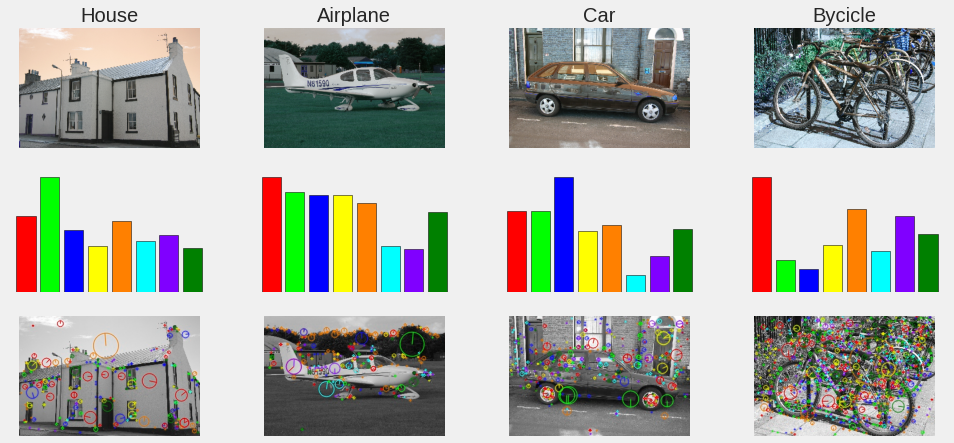

In [ ]:
plot_grids(3, 'colored_results')

As we can see there is not a recognizable pattern of the distribution of clusters for the different classes, indeed it's kind of impossible to assign to one of the objects a subset of gradients nor a group of clusters.

## Classification on the cluster representation
Our goal here is to find out if there is a pattern, trivially invisible to human eyes, exploiting the Multinomial Naive Bayes classifier, this has been choose for its capacity of find nultiple hyperplanes to divide the space in multi classes.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.utils import shuffle

X, y = predictions, target_generator()
X, y = shuffle(X, y, random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.6, random_state=0)

clf = MultinomialNB(force_alpha=True)

y_pred = clf.fit(X_train, y_train).predict(X_test)

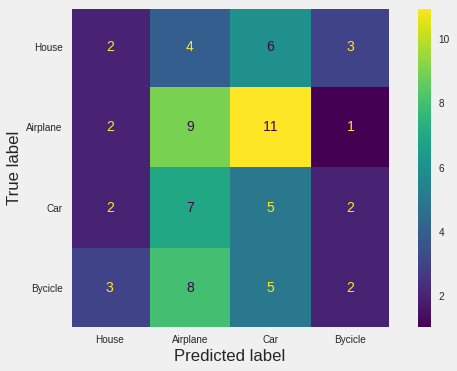

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cls = ['House','Airplane','Car','Bycicle']
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=cls)
disp.plot()
plt.grid(False)
plt.show()

As we can see from the Confusion Matrix the classifier is not capable of correctly classify the compressed descriptor counted as a Bag of Word distribution (here the assumption of counting the values of clusters independently from the order holds because the descriptor keypoint are not kept in mind, Scale, Rotation and Position invariant). 

It can be that after a proper data preparation and inserting prior knowledge on the information extraction phase and using the normalized descriptors instead of the cluster space, we could reach better results.

For now it is not daring to say that the SIFT is a good descriptor, but not a good detector as well, but keeping in mind the year of the publication of this idea, the SIFT it is a really robust and useful model.